# Module 08: Model Evaluation and Calibration (Snow Model)

### 1. Introduction and Background

In this module we focus on calibrating models. In reality, because of the complexity of Earth and environmental processes, the vast majority of models have free parameters that: (1) cannot be measured in the lab or field, (2) involve empirical or statistical relationships that capture the macroscopic behavior of a process but are not based in first principles, and/or (3) are simplifications of complex processes developed to make problems tractable. In this case, we need to calibrate the model by adjusting these parameters such that one or more variables our model is predicting agrees to a reasonable extent with available observations of those same variables. That last sentence is a ___gross___ oversimplification of what calibration is. For example, "adjusting parameters" can involve very complex algorithms that search large parameter spaces searching for parameters to improve model performance. Moreover, what constitutes "reasonable agreement" between models and observations is a product of things like how "agreement" is calculated (performance), what reasonable is in the context of the observations, and the degree to which the observations themselves have errors (measuring stuff is often hard). 

Here we will start with a simple representing snow accumulation and melt that effectively only has two free parameters. It is an entirely empirical model, based on what is known as a temperature-index method, but the model itself is actually the backbone of many operational hydrologic models in snow-dominated areas – the [Snow-17 model](https://www.nrcs.usda.gov/wps/PA_NRCSConsumption/download?cid=nrcseprd1805289&ext=pdf). The Snow-17 model operates at a daily time step, and is effectively composed of two rules. The first rule deals with the accumulation of snow during periods of precipitation:

$$
\Delta \mathrm{SWE} =  
\begin{cases}
    P & P > 0 \mathrm{\quad and \quad} T_a < T_t \\
    0 & \mathrm{Otherwise} \\
\end{cases}
$$

where $\Delta \mathrm{SWE}$ is the change in the snow water equivalent at the given date (mm/day), $P$ is the measured (or forecast) precipitation amount for the day (mm/day), $T_a$ is the measured (or forecast) average air temperature for the day (°C), and $T_t$ is a temperature threshold parameter (in °C) that sets the air temperature above or below which precipitation will fall as rain versus snow. The parameter $T_t$ is also an important parameter in determining when snowmelt will occur. Snowmelt is calculated using the following rule:

$$
S_m = 
\begin{cases}
    D_D\cdot(T_a - T_t) & T_a \geq T_t \mathrm{\quad and \quad} \mathrm{SWE} > 0 \\
    0 & \mathrm{Otherwise}
\end{cases}
$$

where the only new parameter is $D_D$ which is known as the degree-day factor (mm/day/°C). $D_D$ is an empirical factor that transforms the temperature departure above $T_t$ into an amount of melt from the snowpack. 

So, in our model for this week, there will be two parameters that require calibration:
* $T_t$: The threshold temperature used to decide whether precipitation is snow or if snowmelt is occuring, and
* $D_D$: The degree-day factor that will translate positive air temperature departures from $T_t$ into snowmelt rates

The system that we're modeling will be the East River Watershed in western Colorado, the site of a [major Earth science community effort to understand watershed function](https://watershed.lbl.gov/). We will use our model to make predictions of snow water equivalent (SWE) that we will compare against observed observations of SWE from a Snotel station within the watershed that has historically served as a good approximation of the total SWE within the watershed. We will compute a few error statistics relative to the observed historical values of SWE. We have 20 years of forcing data, but will only examine the last 5 years of the record.  

### 2. `Python` Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This is a new, but powerful library for time series analysis and handling real-world dates
import pandas as pd

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

date_beg = '2015-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

dt = 1 # Time step [day]

DD = 3.5 # Trial value of degree-day factor [mm/day/°C] - NOT CALIBRATED
Tt = 0.4 # Trial value of temperature threshold [°C] - NOT CALIBRATED

### 3. Read Forcing Data and Plot

In [2]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,temp,precip,Qcms,PET
Date,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,3.244371
...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,3.412351


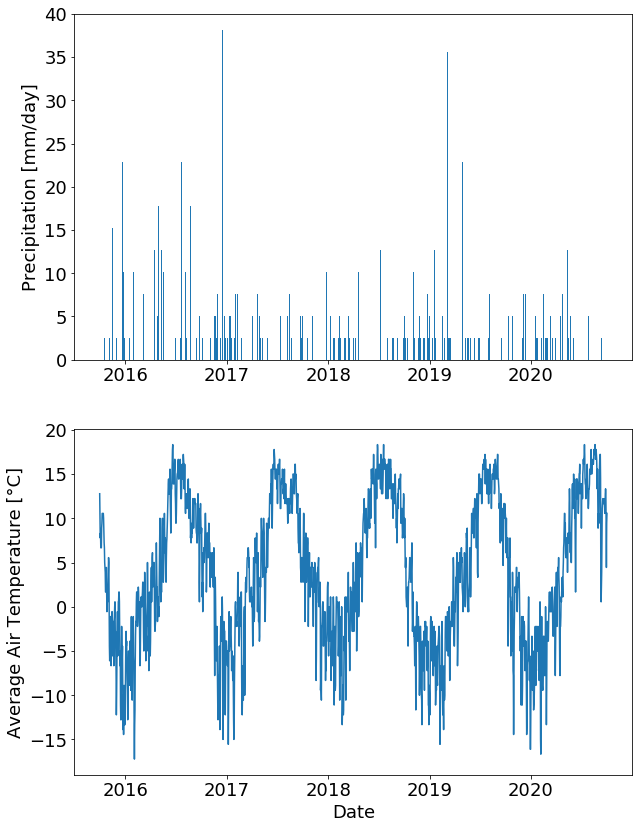

In [3]:
# Plot temperature and precipitation during the period
plt.rcParams.update({'font.size': 18})
plt.subplots(figsize=(10,14))
plt.subplot(2,1,1)
plt.bar(df_forcing['Date'][date_beg:date_end].values,df_forcing['precip'][date_beg:date_end].values)
plt.ylabel('Precipitation [mm/day]')
plt.subplot(2,1,2)
plt.plot(df_forcing['Date'][date_beg:date_end].values,df_forcing['temp'][date_beg:date_end].values)
plt.xlabel('Date')
plt.ylabel('Average Air Temperature [°C]')
plt.show()

### 4. Get Precipitation and Temperature Forcing Data 

Here we use our new `pandas` skills to get the values of the dates, precipitation, and temperature that coincide with the dates that we want to simulate.

In [4]:
ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P = df_forcing[date_beg:date_end]['precip'].values
Ta = df_forcing[date_beg:date_end]['temp'].values

### 5. Create Containers for Modeled Variables

In [5]:
t = pd.date_range(start=date_beg, end=date_end, freq='1D')
Nt = t.size

SWE = np.zeros((Nt))
Sm = np.zeros((Nt))
Pliq = np.zeros((Nt))

### 5. Run the Snow-17 Model

In [6]:
for i in np.arange(Nt):

    P_i  = P[i] # The value of precipitation on this date
    Ta_i = Ta[i] # The value of average air temperature on this date

    # Initial conditions: we are starting when there should not be any appreciable snow in the watershed, 
    # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
    # then you would need a more realistic value of SWE.
    if(i==0):
        SWE_i = 0.0 
    else:
        SWE_i = SWE[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.
        
    # If SWE is greater than zero, there *may* be snowmelt
    if(SWE_i>0.0):
        if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
            Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
        else: # If the air temperature is below the threshold, there is no melt
            Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
    else: # If there is no SWE, by definition there is no snowmelt
        Sm_i = 0.0
    
    # If there is precipitation, figure out its phase
    if((P_i>0.0) and (Ta_i<=Tt)):
        SWE_i += P_i # All precip will be added to SWE storage
        Pliq_i = 0.0 # There is no liquid precipitation
    elif((P_i>0.0) and (Ta_i>Tt)):
        Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
    else: # If there is no precipitation, there is nothing to accumulate
        Pliq_i = 0.0
    
    SWE[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
    Sm[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
    Pliq[i] = Pliq_i


### 6. Plot Results

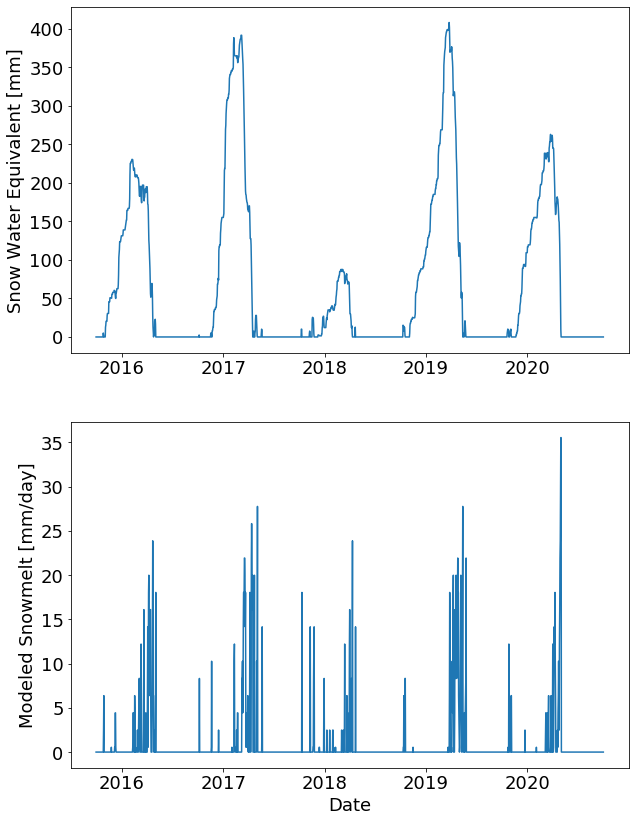

In [7]:
plt.rcParams.update({'font.size': 18})
plt.subplots(figsize=(10,14))
plt.subplot(2,1,1)
plt.plot(t,SWE)
plt.ylabel('Snow Water Equivalent [mm]')
plt.subplot(2,1,2)
plt.plot(t,Sm)
plt.xlabel('Date')
plt.ylabel('Modeled Snowmelt [mm/day]')
plt.show()